In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [5]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions/58-resnet_d2_pred_all.nc')

In [10]:
datadir='/data/stephan/WeatherBench/5.625deg/'
z500_valid = load_test_data(f'{datadir}geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}temperature_850', 't')

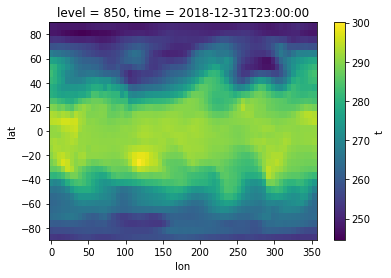

In [15]:
preds.t.sel(time='2018-12-31T23:00:00', level=850).plot()

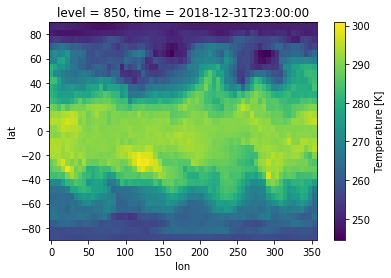

In [16]:
t850_valid.sel(time='2018-12-31T23:00:00').plot()

In [13]:
compute_weighted_rmse(preds.z.sel(level=500), z500_valid).load()

<xarray.DataArray 'z_rmse' ()>
array(343.76215325)
Coordinates:
    level    int64 500

In [14]:
compute_weighted_rmse(preds.t.sel(level=850), t850_valid).load()

<xarray.DataArray 't_rmse' ()>
array(2.08882712)
Coordinates:
    level    int64 850